In [ ]:
#!pip install git+https://github.com/behera116/keras-squeezenet-fixes.git

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/squeezenet_mcs.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/Segmented/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/Segmented/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### SqueezeNet Model

In [3]:
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

base_model = SqueezeNet(input_shape=(224,224,3))
for layer in base_model.layers:
        layer.trainable = False

snet_extract = base_model.layers[-3].output
snet_extract = tf.keras.layers.GlobalAveragePooling2D()(snet_extract)
snet_extract = tf.keras.layers.Dropout(0.4)(snet_extract)
output = tf.keras.layers.Dense(3, activation='softmax')(snet_extract)

squeezenet_model = Model(base_model.input, output)
squeezenet_model.summary()

2022-08-28 11:06:09.829973: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-28 11:06:09.830055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12008 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 111, 111, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 111, 111, 64  0           ['conv1[0][0]']                  
                                )                                                             

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(squeezenet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(squeezenet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 7566 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.7479240806642942, 1: 0.8135483870967742, 2: 2.3053016453382082}
samples for train class labels: dict_items([(0, 3372), (1, 3100), (2, 1094)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 702), (1, 600), (2, 249)])


#### SqueezeNet Compilation and Execution

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
warnings.filterwarnings("ignore")
epochs = 20
history = squeezenet_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/20


2022-08-28 11:06:23.169531: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


237/237 [==============================] - ETA: 0s - loss: 11.8902 - accuracy: 0.3758 - AUC: 0.5414 - precision: 0.3757 - recall: 0.3750
Epoch 00001: val_loss improved from inf to 4.13212, saving model to ./weights/squeezenet_mcs.hdf5
End of epoch 0. Learning rate: 0.001
237/237 [==============================] - 105s 428ms/step - loss: 11.8902 - accuracy: 0.3758 - AUC: 0.5414 - precision: 0.3757 - recall: 0.3750 - val_loss: 4.1321 - val_accuracy: 0.3759 - val_AUC: 0.5833 - val_precision: 0.3765 - val_recall: 0.3746 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 7.4263 - accuracy: 0.4621 - AUC: 0.6165 - precision: 0.4625 - recall: 0.4611
Epoch 00002: val_loss improved from 4.13212 to 1.85686, saving model to ./weights/squeezenet_mcs.hdf5
End of epoch 1. Learning rate: 0.001
237/237 [==============================] - 102s 428ms/step - loss: 7.4263 - accuracy: 0.4621 - AUC: 0.6165 - precision: 0.4625 - recall: 0.4611 - val_loss: 1

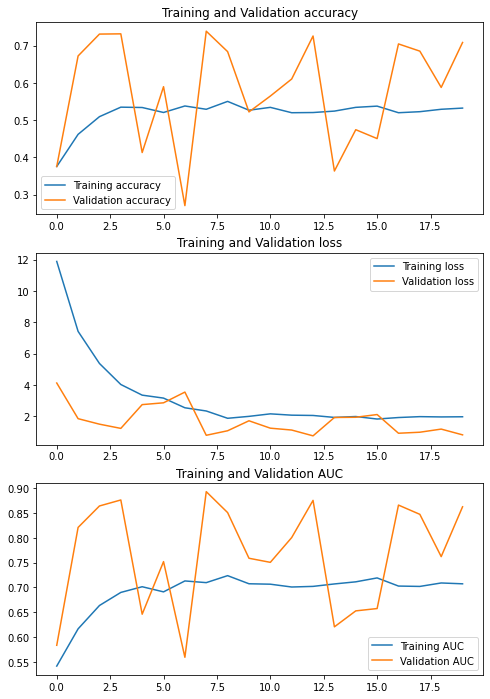

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
12,2.061421,0.520619,0.702140,0.526795,0.511895,0.760718,0.725983,0.875627,0.745868,0.698259,0.001
7,2.347393,0.529342,0.709705,0.532910,0.521147,0.796518,0.738878,0.893202,0.756342,0.730496,0.001
19,1.978225,0.532514,0.707332,0.538346,0.520486,0.824039,0.708575,0.862686,0.730429,0.691812,0.001
16,1.929802,0.520090,0.702792,0.526546,0.509913,0.927242,0.704707,0.866121,0.715811,0.691812,0.001
17,1.986392,0.522865,0.702064,0.527218,0.508195,0.992057,0.685364,0.847463,0.695212,0.664732,0.001
8,1.881382,0.550489,0.723794,0.554407,0.538726,1.085465,0.684075,0.850994,0.694242,0.676338,0.001
11,2.080220,0.520090,0.700884,0.524867,0.509120,1.131251,0.610574,0.800615,0.630556,0.585429,0.001
18,1.967818,0.529342,0.709027,0.535577,0.517314,1.191919,0.588008,0.762192,0.591919,0.566731,0.001
3,4.037323,0.535025,0.689963,0.537180,0.532778,1.236679,0.731786,0.876438,0.737769,0.729207,0.001


In [10]:
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [11]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune = squeezenet_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/35
237/237 [==============================] - ETA: 0s - loss: 0.5475 - accuracy: 0.7869 - AUC: 0.9217 - precision: 0.8224 - recall: 0.7465
Epoch 00020: val_loss improved from 0.76072 to 0.44167, saving model to ./weights/squeezenet_mcs.hdf5
End of epoch 19. Learning rate: 1e-04
237/237 [==============================] - 100s 410ms/step - loss: 0.5475 - accuracy: 0.7869 - AUC: 0.9217 - precision: 0.8224 - recall: 0.7465 - val_loss: 0.4417 - val_accuracy: 0.8266 - val_AUC: 0.9500 - val_precision: 0.8494 - val_recall: 0.8072 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 21/35
237/237 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8689 - AUC: 0.9680 - precision: 0.8857 - recall: 0.8467
Epoch 00021: val_loss did not improve from 0.44167
End of epoch 20. Learning rate: 1e-04
237/237 [==============================] - 96s 407ms/step - loss: 0.3451 - accuracy: 0.8689 - AUC: 0.9680 - precision: 0.8857 - recall: 0.8467 - v

In [12]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune = squeezenet_model.fit(train_generator,
                            epochs=45,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 20/45
237/237 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9545 - AUC: 0.9959 - precision: 0.9581 - recall: 0.9508
Epoch 00020: val_loss did not improve from 0.28812
End of epoch 19. Learning rate: 1e-05
237/237 [==============================] - 106s 437ms/step - loss: 0.1162 - accuracy: 0.9545 - AUC: 0.9959 - precision: 0.9581 - recall: 0.9508 - val_loss: 0.5305 - val_accuracy: 0.7956 - val_AUC: 0.9333 - val_precision: 0.8047 - val_recall: 0.7892 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 21/45
237/237 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9560 - AUC: 0.9964 - precision: 0.9591 - recall: 0.9537
Epoch 00021: val_loss did not improve from 0.28812
End of epoch 20. Learning rate: 1e-05
237/237 [==============================] - 103s 434ms/step - loss: 0.1084 - accuracy: 0.9560 - AUC: 0.9964 - precision: 0.9591 - recall: 0.9537 - val_loss: 0.5295 - val_accuracy: 0.7975 - val_AUC: 

In [13]:
import pandas as pd
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
8,0.092386,0.963257,0.997378,0.964196,0.961010,0.451076,0.826564,0.954342,0.835410,0.821406,0.000010
9,0.095460,0.964578,0.996920,0.966826,0.962992,0.503092,0.811734,0.943993,0.817885,0.807866,0.000010
2,0.106151,0.959688,0.996463,0.961717,0.956252,0.511124,0.808511,0.941961,0.814014,0.801418,0.000010
12,0.093208,0.963785,0.997097,0.966162,0.962331,0.512679,0.816892,0.944075,0.824492,0.811734,0.000010
1,0.108364,0.955987,0.996435,0.959064,0.953740,0.529478,0.797550,0.936532,0.808804,0.793682,0.000010
0,0.116247,0.954533,0.995923,0.958050,0.950833,0.530549,0.795616,0.933276,0.804734,0.789168,0.000010
13,0.093682,0.964314,0.997154,0.966383,0.961274,0.572769,0.792392,0.932319,0.797775,0.785945,0.000010
3,0.101165,0.962596,0.996487,0.964518,0.959292,0.605297,0.779497,0.924740,0.785855,0.773694,0.000010
17,0.087344,0.966561,0.997577,0.968315,0.965371,0.609720,0.788524,0.927337,0.796968,0.779497,0.000010


#### Test Image Generation for prediction

In [14]:
model =  tf.keras.models.load_model('./weights/squeezenet_mcs.hdf5')

#### Shenzhen Dataset Evaluation

In [15]:
TEST_IMAGE_FOLDER = '/home/TBX11K/Segmented/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 134 images belonging to 3 classes.


In [16]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9000    0.6818    0.7759        66
           2     0.7500    0.9265    0.8289        68

    accuracy                         0.8060       134
   macro avg     0.8250    0.8041    0.8024       134
weighted avg     0.8239    0.8060    0.8028       134



#### Montgomery Countery Evaluation

In [17]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 28 images belonging to 3 classes.


In [18]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9000    0.5625    0.6923        16
           2     0.6111    0.9167    0.7333        12

    accuracy                         0.7143        28
   macro avg     0.7556    0.7396    0.7128        28
weighted avg     0.7762    0.7143    0.7099        28

